# Magic data analysis

### Description

The data are Monte Carlo generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). 

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions. 

The program was run with parameters allowing to observe events with energies down to below 50 GeV.

### Dataset

The dataset is available at this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data)

Attribute Information:

1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: g,h # gamma (signal), hadron (background) 

g = gamma (signal): 12332 
h = hadron (background): 6688 

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events. 

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.


### References

Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004). 
Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. 
Nucl.Instr.Meth. A, 516, pp. 511-528. 

P. Savicky, E. Kotrc. 
Experimental Study of Leaf Confidences for Random Forest. 
Proceedings of COMPSTAT 2004, In: Computational Statistics. (Ed.: Antoch J.) - Heidelberg, Physica Verlag 2004, pp. 1767-1774. 

J. Dvorak, P. Savicky. 
Softening Splits in Decision Trees Using Simulated Annealing. 
Proceedings of ICANNGA 2007, Warsaw, (Ed.: Beliczynski et. al), Part I, LNCS 4431, pp. 721-729.

Aharonian, F. et al.
The Energy Spectrum of TeV Gamma-Rays from the Crab Nebula as measured by the HEGRA system of imaging air Cherenkov telescopes
Astrophys. J. 539 (2000) 317-324

Aleksic, J. et al.
Measurement of the Crab Nebula spectrum over three decades in energy with the MAGIC telescopes
Journal of High Energy Astrophysics, 5–6 (2015) 30-38.

### Assignments

The main goal is to distinguish signal and background events. Two approaches can be followed: 1) exploiting the physics of the detection principle 2) use a physics-agnostic multivariate technique, e.g. a neural network.

* Study the features of the datasets and compare them for signal and background events
* Study the correlations among the features of the datasets for signal and background events
* Compute the "mean-scaled-width" and the "mean-scale-length", i.e. rescale by means of their mean and standard deviation the "Width" and "Length" distributions. Compare them for signal and background events in the cases of little or a lot of light ("fSize") 
* Perform a Principal Component Analysis on that dataset for the signal and the background events
* Perform a multivariate analysis, without using the parameter `fAlpha` for the classification, with the technique you prefer and evaluate its performance (e.g. in terms of Area Under the (ROC) Curve).
*  If we call "gammaness" the score that you give when you classify an event as gamma or hadron (that has been trained without using `fAlpha`), find the gammaness and alpha cuts that are giving the highest quality factor. 

Since you have a dataset that does not correspond to reality (in which hadrons are much more numerous than gammas), we define the quality factor **Q** as:
    
   **Q** = epsilon_gamma / sqrt(epsilon_hadron); where
   
   epsilon_gamma = selected_gammas / total_number_of_gammas
   
   epsilon_hadron = selected_hadrons / total_number_of_hadrons

* Assuming that the telescope has a collection area of 10^9 cm^2 and that we are observing gamma rays between 50 GeV and 50 TeV, to what observation time does this measurement corresponds? (assume here the Crab spectrum measured by HEGRA [Aharonian, F. et al. 2000])
* Do the same using the MAGIC measured spectrum of the Crab Nebula [Aleksic, J. et al. 2015]
* Plot both spectra and answer if the difference in the observation time that you are obtaining goes in the direction of the difference in the spectra that you are plotting.


### Contacts

* Ruben Lopez <ruben.lopezcoto@pd.infn.it>, (who is unfortunately not in Padova any more.., his group must be contacted instead, like prof. Michele Doro)


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import sklearn.metrics as skm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree

In [2]:
# FEATURES PLOT

def features_plot(df1, df2, features, title):

    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,10))

    udm = ['mm', 'mm', '#photons', '#photons ratio', '#photons ratio', 'mm', 'mm', 'mm', 'degrees', 'mm']

    bins = 50

    for i in range(2):
        for j in range(5):
            if df1[features[5*i+j]].std() < 1:
                siglabel = f'signal mean: {df1[features[5*i+j]].mean():.2f}±{df1[features[5*i+j]].std():.2f}'
                bkglabel = f'bkg mean: {df2[features[5*i+j]].mean():.2f}±{df2[features[5*i+j]].std():.2f}'
            else:
                siglabel = f'signal mean: {df1[features[5*i+j]].mean():.0f}±{df1[features[5*i+j]].std():.0f}'
                bkglabel = f'bkg mean: {df2[features[5*i+j]].mean():.0f}±{df2[features[5*i+j]].std():.0f}'

            counts_sig, _ = np.histogram(df1[features[5*i+j]], bins = bins, density=True)
            counts_bkg, _ = np.histogram(df2[features[5*i+j]], bins = bins, density=True)

            ax[i][j].hist(x=df1[features[5*i+j]], bins = bins, density=True, alpha = 0.6, color='C1')
            ax[i][j].hist(x=df2[features[5*i+j]], bins = bins, density=True, alpha = 0.5, color = 'C0')

            ax[i][j].vlines(x=df1[features[5*i+j]].mean(), ymin=0, ymax=counts_sig.max(), label=siglabel, color = 'C1')
            ax[i][j].vlines(x=df2[features[5*i+j]].mean(), ymin=0, ymax=
            counts_bkg.max(), label=bkglabel, color = 'C0')

            ax[i][j].set_xlabel(udm[5*i+j])
            ax[i][j].set_ylabel('pdf')
            ax[i][j].set_title(features[5*i+j], fontsize=14)
            ax[i][j].legend(loc='best', fontsize=12)

    fig.suptitle(title, fontsize=30)
    fig.legend(['signal', 'bkg'], loc = 'right', fontsize=20)

    plt.show()

### 1. Study the fratures of the dataset and compare them form signal and background events

In [4]:
# read and import data
data = pd.read_csv('magic04.data')
features = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
data.columns = features

# converting sig to 1 and bkg to 0
data_c = data.copy(deep=True)
data_c['class'] = np.where(data['class']=='g',1,0)

Y = data_c['class']

data_c.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.261,1
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.788,1
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.737,1
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.462,1
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.098,1


In [5]:
# dataset dimension and label frequencies
print('Dataset dimension:', data.shape)
ylab, yfreq = np.unique(Y, return_counts=True)
print('Labels and their relative frequencies:')
print(f' - background:\tlabel {ylab[0]} \t {100*yfreq[0]/data.shape[0]:.2f}%')
print(f' - signal:\tlabel {ylab[1]} \t {100*yfreq[1]/data.shape[0]:.2f}%')

Dataset dimension: (19019, 11)
Labels and their relative frequencies:
 - background:	label 0 	 35.16%
 - signal:	label 1 	 64.84%


In [6]:
# separating signal and bkg data
datasig = data_c[data_c['class']==1]
databkg = data_c[data_c['class']==0]

datasig = datasig.drop(columns='class')
databkg = databkg.drop(columns='class')

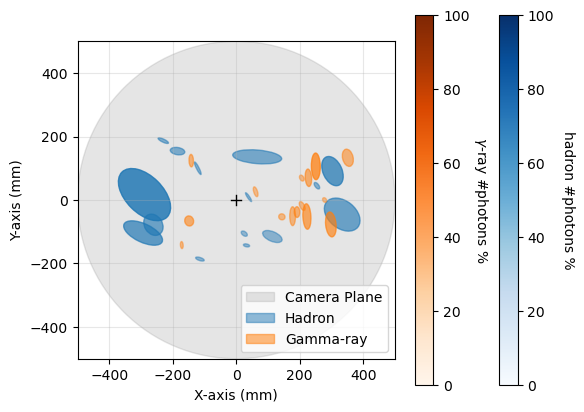

In [7]:
# visualize data
n_ellipses = 15

# ellipse parameters
sig_idx = np.random.randint(0,10000, size=n_ellipses)
sig_ellipse_params = [ 
    {
        'center': (np.random.choice([-1,1])*datasig['fDist'][idx],np.random.randint(-datasig['fDist'].mean(), datasig['fDist'].mean())), 
        'width': datasig['fWidth'][idx], 
        'height': datasig['fLength'][idx], 
        'angle': datasig['fAlpha'][idx],
        'alpha': datasig['fSize'][idx]/data_c['fSize'].max()
        } 
    for idx in sig_idx
    ]

bkg_idx = np.random.randint(13000,19000, size=n_ellipses)
bkg_ellipse_params = [ 
    {
        'center': (np.random.choice([-1,1])*databkg['fDist'][idx],np.random.randint(-databkg['fDist'].mean(), databkg['fDist'].mean())), 
        'width': databkg['fWidth'][idx], 
        'height': databkg['fLength'][idx], 
        'angle': databkg['fAlpha'][idx],
        'alpha': databkg['fSize'][idx]/data_c['fSize'].max()
        } 
    for idx in bkg_idx
    ]

fig, ax = plt.subplots()

ax.grid(alpha=0.3)

# plot ellipses
radius = 500
camera_circle = patches.Circle((0,0), radius, alpha=0.2, color='grey')
ax.add_patch(camera_circle)

bkg_ellipses = []
sig_ellipses = []

for params in bkg_ellipse_params:
    ellipse = patches.Ellipse(xy=params['center'], width=params['width'], height=params['height'], angle=params['angle'], fill=True, alpha=params['alpha'], color='C0')
    ax.add_patch(ellipse)
    bkg_ellipses.append(ellipse)

for params in sig_ellipse_params:
    ellipse = patches.Ellipse(xy=params['center'], width=params['width'], height=params['height'], angle=params['angle'], fill=True, alpha=params['alpha'], color='C1')
    ax.add_patch(ellipse)
    sig_ellipses.append(ellipse)

ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_aspect('equal')

legend_labels = ['Camera Plane', 'Hadron', 'Gamma-ray']
legend_handles = [camera_circle, bkg_ellipses[0], sig_ellipses[0]]
ax.legend(legend_handles, legend_labels, loc='lower right')

center_cross_size = 15
ax.plot([0, 0], [-center_cross_size, center_cross_size], color='black', linewidth=1)
ax.plot([-center_cross_size, center_cross_size], [0, 0], color='black', linewidth=1)

# color scale indicating alpha for background ellipses
bkg_alphas = [params['alpha'] for params in bkg_ellipse_params]
bkg_norm = Normalize(vmin=0, vmax=100)
bkg_scalar_map = ScalarMappable(norm=bkg_norm, cmap='Blues')
bkg_scalar_map.set_array(bkg_alphas)
bkg_colorbar = plt.colorbar(bkg_scalar_map, ax=ax)
bkg_colorbar.set_label('hadron #photons %', rotation=270, labelpad=15)

# color scale indicating alpha for signal ellipses
sig_alphas = [params['alpha'] for params in sig_ellipse_params]
sig_norm = Normalize(vmin=0, vmax=100)
sig_scalar_map = ScalarMappable(norm=sig_norm, cmap='Oranges')
sig_scalar_map.set_array(sig_alphas)
sig_colorbar = plt.colorbar(sig_scalar_map, ax=ax)
sig_colorbar.set_label('$\gamma$-ray #photons %', rotation=270, labelpad=15)

ax.set_xlabel('X-axis (mm)')
ax.set_ylabel('Y-axis (mm)')

plt.show()

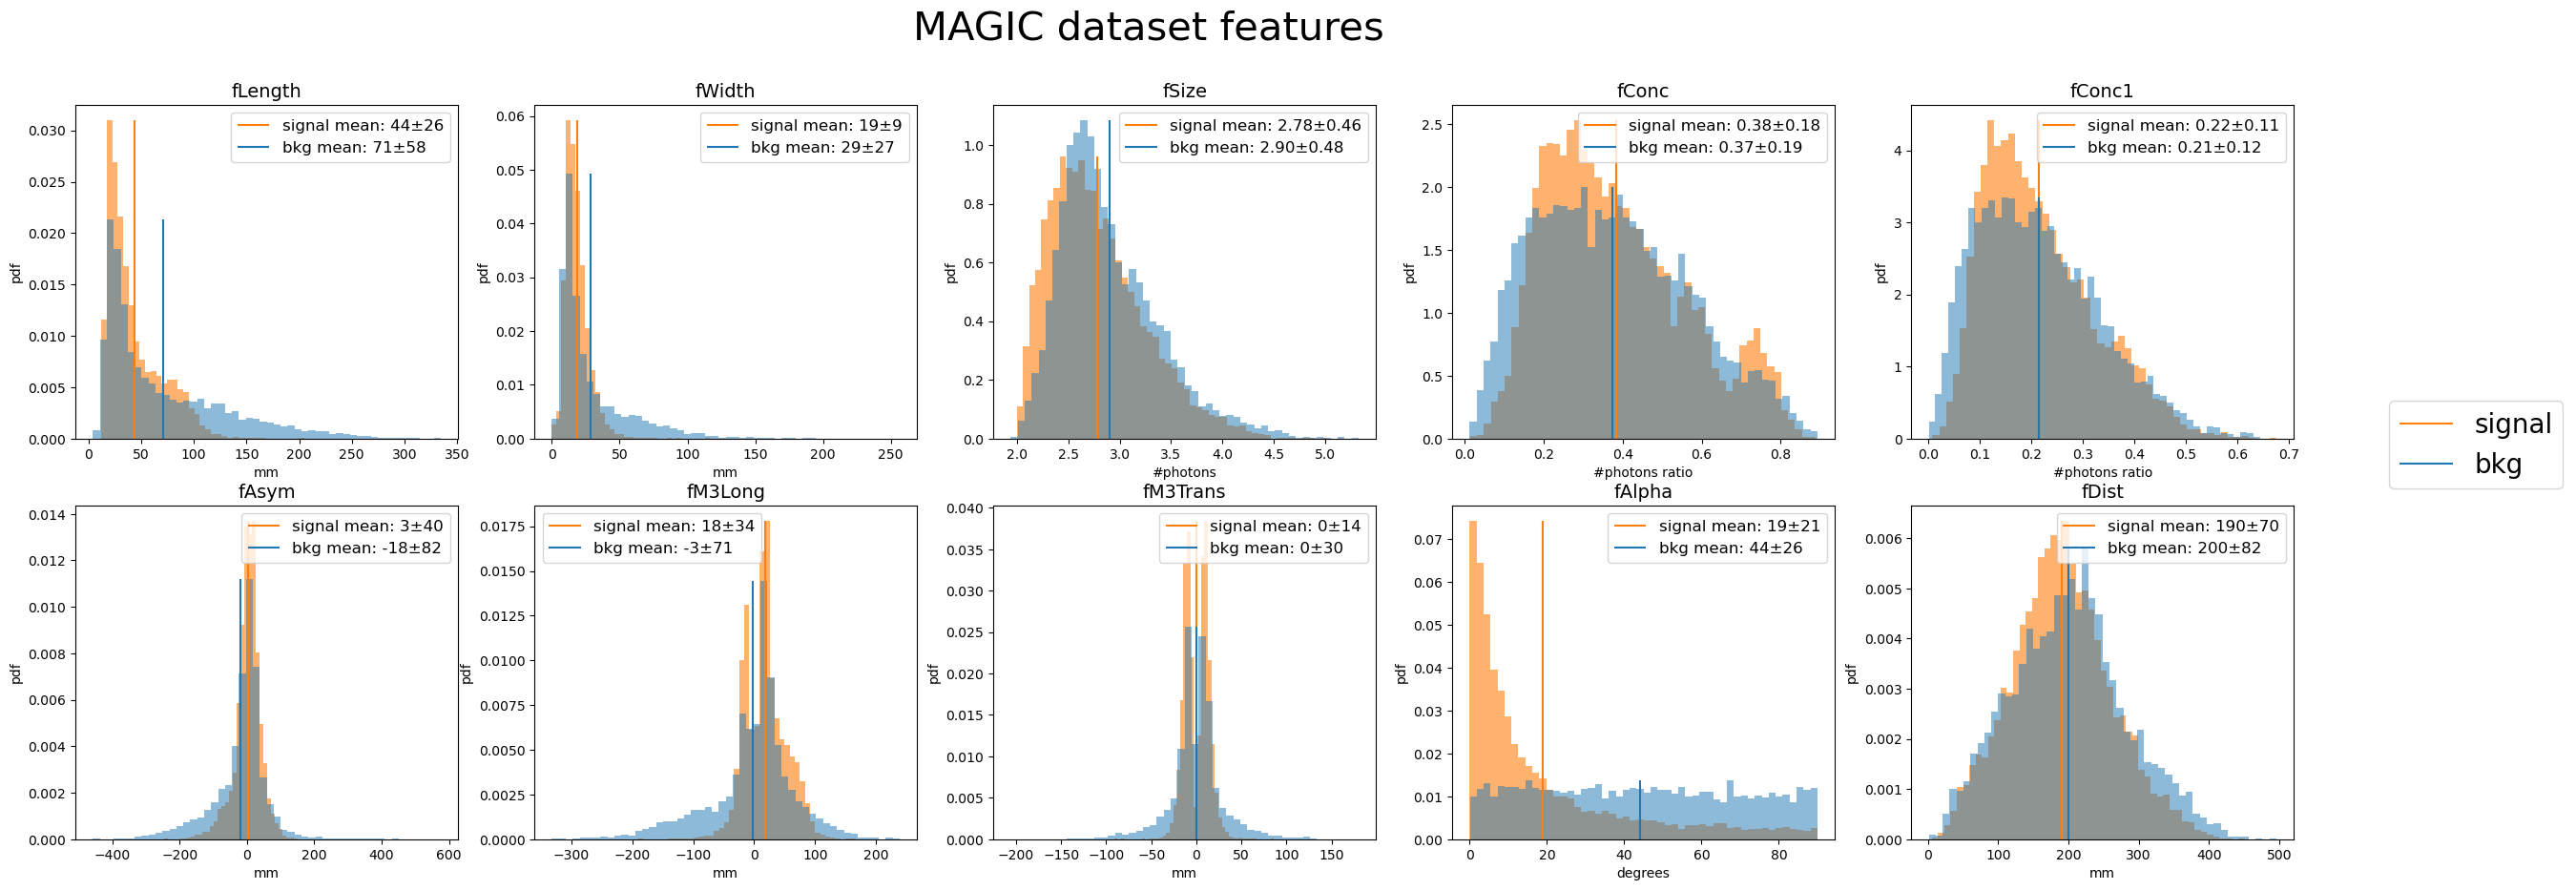

In [7]:
# plot
features_plot(datasig, databkg, features, 'MAGIC dataset features')

### 2. Study the correlations

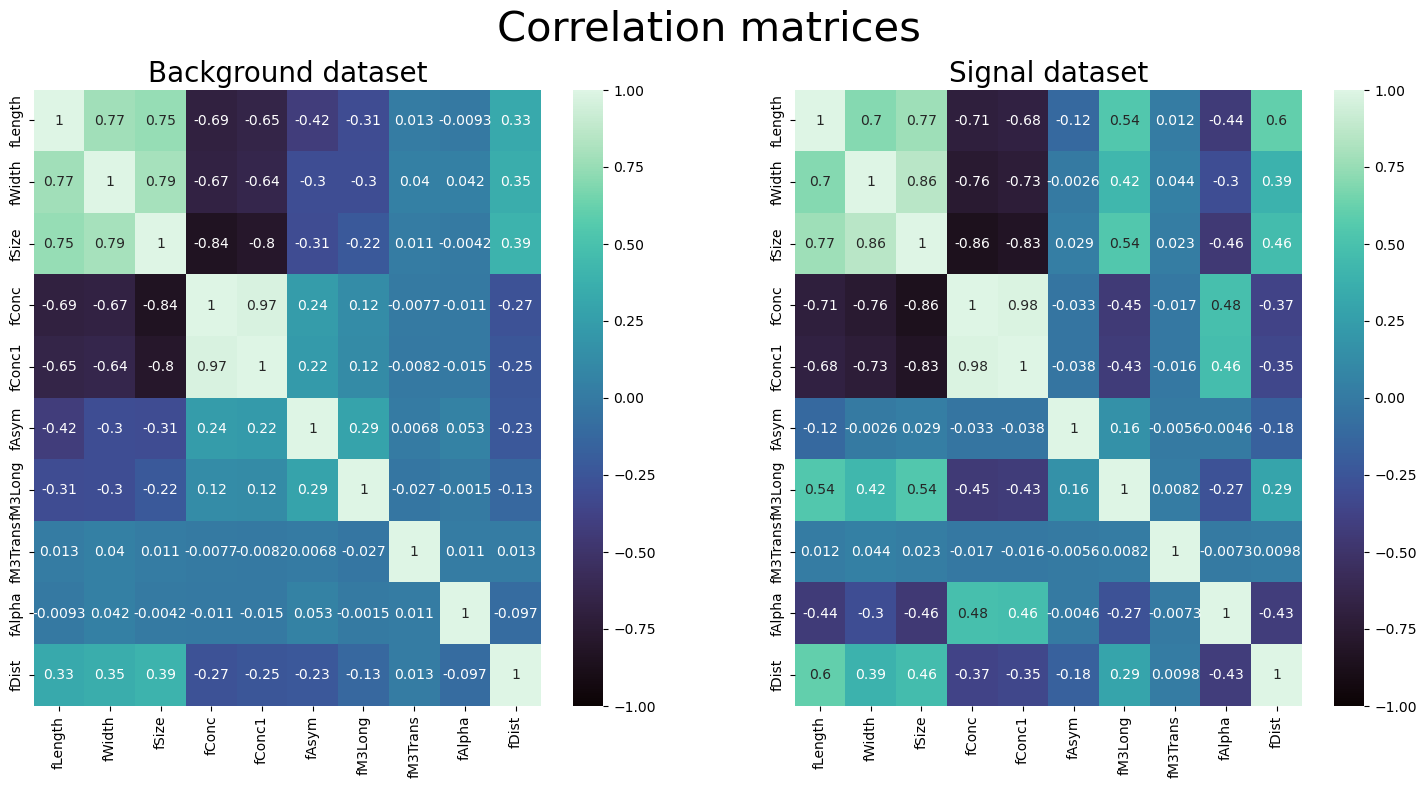

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

fig.suptitle('Correlation matrices', fontsize=30)

sns.heatmap(databkg.corr(), annot=True, vmin=-1, vmax=1, ax=ax[0], cmap='mako')
sns.heatmap(datasig.corr(), annot=True, vmin=-1, vmax=1, ax=ax[1], cmap='mako')

ax[0].set_title('Background dataset', fontsize=20)
ax[1].set_title('Signal dataset', fontsize=20)

plt.show()

/Users/giuliadoda/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


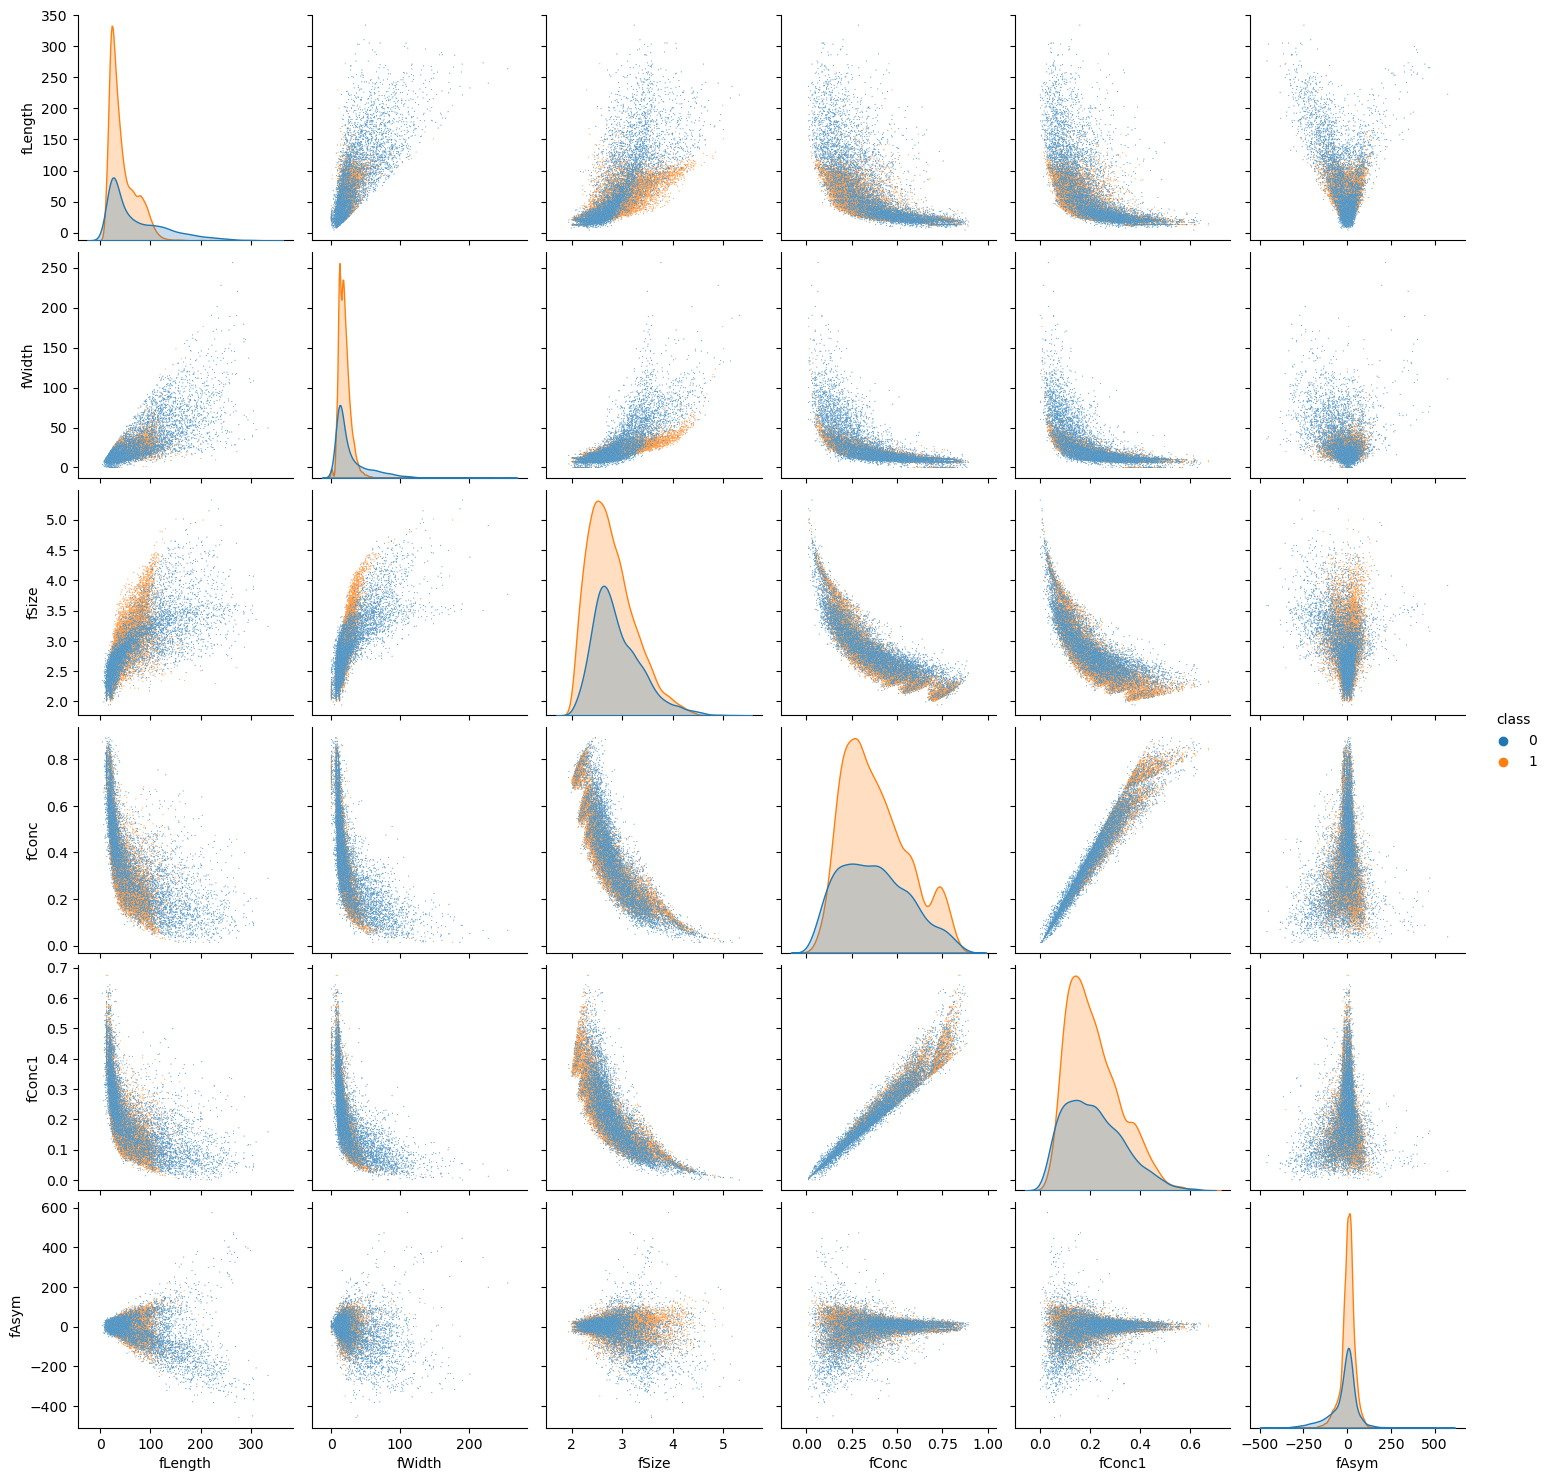

In [9]:
# pairplot with some features to visualize correlations
sns.pairplot(data_c, hue='class', plot_kws={'s':0.5}, vars = features[0:6])

### 3. Rescaled Width&Length

In [8]:
# rescaling Width and Length 
wmean = data_c['fWidth'].mean()
wstd = data_c['fWidth'].std()

lmean = data_c['fLength'].mean()
lstd = data_c['fLength'].std()

data_rescaled = data_c.copy(deep=True)
data_rescaled['fWidth'] = (data_rescaled['fWidth']-wmean)/wstd
data_rescaled['fLength'] = (data_rescaled['fLength']-lmean)/lstd

# splitting in high number of photons and low
smean = data_rescaled['fSize'].mean()
sstd = data_rescaled['fSize'].std()

data_highs = data_rescaled[data_rescaled['fSize'] >= (smean+sstd)]
data_lows = data_rescaled[data_rescaled['fSize'] <= (smean-sstd)]

/Users/giuliadoda/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/giuliadoda/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


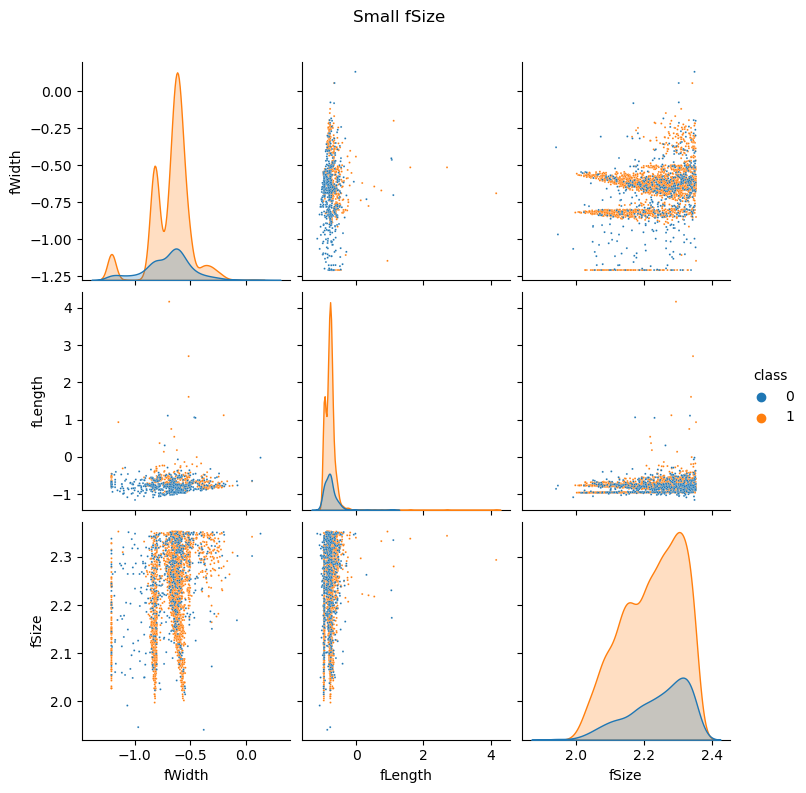

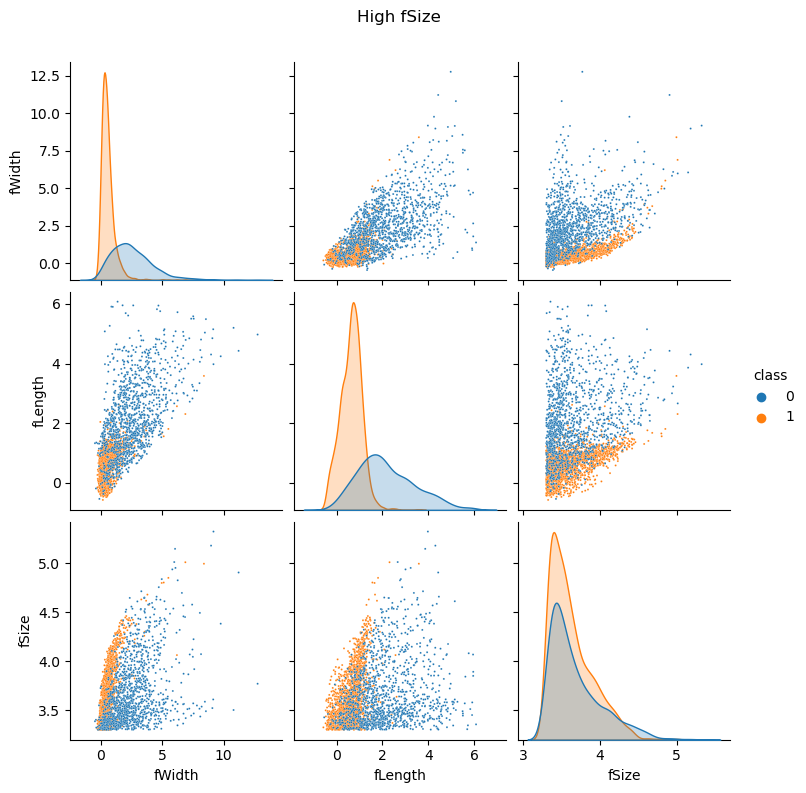

In [11]:
# plot

lowp = sns.pairplot(data_lows, hue='class', plot_kws={'s':2}, vars=['fWidth', 'fLength', 'fSize'])
lowp.fig.suptitle('Small fSize', y=1.05)

highp = sns.pairplot(data_highs, hue='class', plot_kws={'s':2}, vars=['fWidth', 'fLength', 'fSize'])
highp.fig.suptitle('High fSize', y=1.05)

plt.show()

### 4. PCA

In [12]:
# to do

### 5. Classification

In [11]:
# preparing datasets

X = data_c.copy(deep=True)
X = data_c.drop(columns='class')

# calculating mean and std to normalize dataset before analysis
mean_all = X.mean(axis=0)
std_all = X.std(axis=0)

np.random.seed(13012023)

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3)
X_train, X_val, Y_train, Y_val = train_test_split( X_train, Y_train, test_size=0.15)
X_test1, X_test2, Y_test1, Y_test2 = train_test_split(X_test, Y_test, test_size=0.5)

X_train_no_alpha = (X_train-mean_all)/std_all
X_train_no_alpha = X_train_no_alpha.drop(columns='fAlpha')
_, freq_train = np.unique(Y_train, return_counts=True)
print('Training set size:', Y_train.size)
print(f'Frequencies in training set: \n - bkg {freq_train[0]} ({100*freq_train[0]/Y_train.size:.1f}%) \n - signal {freq_train[1]} ({100*freq_train[1]/Y_train.size:.1f}%)')

X_val_no_alpha = (X_val-mean_all)/std_all
X_val_no_alpha = X_val_no_alpha.drop(columns='fAlpha')
_, freq_val = np.unique(Y_val, return_counts=True)
print('\nValidation set tize:', Y_val.size)
print(f'Frequencies in validation set: \n - bkg {freq_val[0]} ({100*freq_val[0]/Y_val.size:.1f}%) \n - signal {freq_val[1]} ({100*freq_val[1]/Y_val.size:.1f}%)')

X_test1_no_alpha = (X_test1-mean_all)/std_all
X_test1_no_alpha = X_test1_no_alpha.drop(columns='fAlpha')
_, freq_test1 = np.unique(Y_test1, return_counts=True)
print('\nFirst test set size:', Y_test1.size)
print(f'Frequencies in training set: \n - bkg {freq_test1[0]} ({100*freq_test1[0]/Y_test1.size:.1f}%) \n - signal {freq_test1[1]} ({100*freq_test1[1]/Y_test1.size:.1f}%)')

X_test2_no_alpha = (X_test2-mean_all)/std_all
X_test2_no_alpha = X_test2_no_alpha.drop(columns='fAlpha')
_, freq_test2 = np.unique(Y_test2, return_counts=True)
print('\nFirst test set size:', Y_test2.size)
print(f'Frequencies in training set: \n - bkg {freq_test2[0]} ({100*freq_test2[0]/Y_test2.size:.1f}%) \n - signal {freq_test2[1]} ({100*freq_test2[1]/Y_test2.size:.1f}%)')

Training set size: 11316
Frequencies in training set: 
 - bkg 3986 (35.2%) 
 - signal 7330 (64.8%)

Validation set tize: 1997
Frequencies in validation set: 
 - bkg 707 (35.4%) 
 - signal 1290 (64.6%)

First test set size: 2853
Frequencies in training set: 
 - bkg 1007 (35.3%) 
 - signal 1846 (64.7%)

First test set size: 2853
Frequencies in training set: 
 - bkg 988 (34.6%) 
 - signal 1865 (65.4%)


### 5.1 SVM

In [12]:
# define SVM model, then train and test
# polynomial kernel
C_par_poly = 15
gamma_par_poly = 0.1
print('\nC parameter for polynomial kernels:', C_par_poly)
print('gamma parameter for polynomial kernels:', gamma_par_poly)
# degree 2
poly2_svm = SVC(kernel='poly', degree=2, C=C_par_poly, gamma=gamma_par_poly, probability = True)
poly2_svm.fit(X_train_no_alpha, Y_train)
poly2_svm_predict = poly2_svm.predict(X_val_no_alpha)
poly2_svm_accuracy = skm.accuracy_score(Y_val, poly2_svm_predict)
print(f'\nPolynomial kernel with degree=2 accuracy: {poly2_svm_accuracy:.3f}')
probpoly2 = poly2_svm.predict_proba(X_val_no_alpha)
roc_auc_poly2 = skm.roc_auc_score(Y_val, probpoly2[:,1])
print(f'Polynomial kernel with degree=2 area under ROC: {roc_auc_poly2:.3f}')

# degree 3
poly3_svm = SVC(kernel='poly', degree=3, C=C_par_poly, gamma=gamma_par_poly, probability = True)
poly3_svm.fit(X_train_no_alpha, Y_train)
poly3_svm_predict = poly3_svm.predict(X_val_no_alpha)
poly3_svm_accuracy = skm.accuracy_score(Y_val, poly3_svm_predict)
print(f'\nPolynomial kernel with degree=3 accuracy: {poly3_svm_accuracy:.3f}')
probpoly3 = poly3_svm.predict_proba(X_val_no_alpha)
roc_auc_poly3 = skm.roc_auc_score(Y_val, probpoly3[:,1])
print(f'Polynomial kernel with degree=3 area under ROC: {roc_auc_poly3:.3f}')

# degree 4
poly4_svm = SVC(kernel='poly', degree=4, C=C_par_poly, gamma=gamma_par_poly, probability = True)
poly4_svm.fit(X_train_no_alpha, Y_train)
poly4_svm_predict = poly4_svm.predict(X_val_no_alpha)
poly4_svm_accuracy = skm.accuracy_score(Y_val, poly4_svm_predict)
print(f'\nPolynomial kernel with degree=4 accuracy: {poly4_svm_accuracy:.3f}')
probpoly4 = poly4_svm.predict_proba(X_val_no_alpha)
roc_auc_poly4 = skm.roc_auc_score(Y_val, probpoly4[:,1])
print(f'Polynomial kernel with degree=4 area under ROC: {roc_auc_poly4:.3f}')

# RBF kernel
rbf_svm = SVC(kernel='rbf', C=10, gamma=1, probability = True)
rbf_svm.fit(X_train_no_alpha, Y_train)
rbf_svm_predict = rbf_svm.predict(X_val_no_alpha)
rbf_svm_accuracy = skm.accuracy_score(Y_val, rbf_svm_predict)
print(f'\nRBF kernel accuracy: {rbf_svm_accuracy:.3f}')
probrbf = rbf_svm.predict_proba(X_val_no_alpha)
roc_auc_rbf = skm.roc_auc_score(Y_val, probrbf[:,1])
print(f'RBF kernel area under ROC: {roc_auc_rbf:.3f}')


C parameter for polynomial kernels: 15
gamma parameter for polynomial kernels: 0.1

Polynomial kernel with degree=2 accuracy: 0.780
Polynomial kernel with degree=2 area under ROC: 0.834

Polynomial kernel with degree=3 accuracy: 0.751
Polynomial kernel with degree=3 area under ROC: 0.810

Polynomial kernel with degree=4 accuracy: 0.760
Polynomial kernel with degree=4 area under ROC: 0.816

RBF kernel accuracy: 0.808
RBF kernel area under ROC: 0.842


Best kernel is RBF, so we perform a grid search for the best gamma parameter.

Highest test accuracy: 0.822 	 Corresponding gamma parameter: 0.25

Highest area under ROC: 0.865 	 Corresponding gamma parameter: 0.25


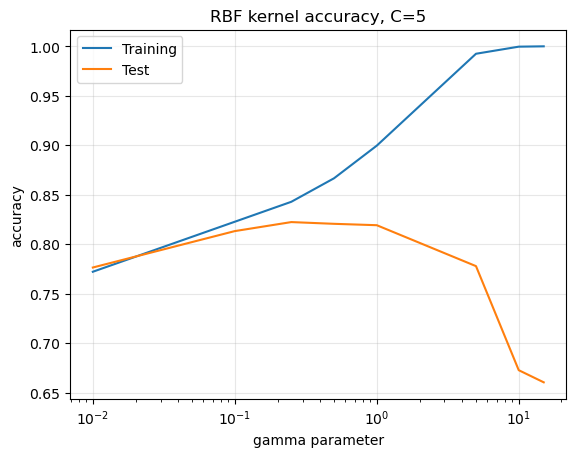

In [13]:
# parameter and models
gamma_values = [0.01, 0.1, 0.25, 0.5, 1, 5, 10, 15]
RBFmodels = [SVC(kernel='rbf', C=5, gamma=i, probability = True) for i in gamma_values]

# train every model
for mod in RBFmodels:
    mod.fit(X_train_no_alpha, Y_train)

# make predictions on test set with every model
RBFtrain_predictions = [mod.predict(X_train_no_alpha) for mod in RBFmodels]
RBFtest_predictions = [mod.predict(X_test1_no_alpha) for mod in RBFmodels]

# calculate train and test accuracy
RBFtrain_acc_list = [ skm.accuracy_score(Y_train, pred) for pred in RBFtrain_predictions ]
RBFtest_acc_list = [ skm.accuracy_score(Y_test1, pred) for pred in RBFtest_predictions ]

# calculate area under ROC
RBF_prob_pred = [mod.predict_proba(X_test1_no_alpha) for mod in RBFmodels]
RBF_areaunderROC = [skm.roc_auc_score(Y_test1, prob[:,1]) for prob in RBF_prob_pred]

best_idx = np.argmax(RBFtest_acc_list)
print(f'Highest test accuracy: {np.max(RBFtest_acc_list):.3f} \t Corresponding gamma parameter: {gamma_values[best_idx]}')

best_roc = np.argmax(RBF_areaunderROC)
print(f'\nHighest area under ROC: {np.max(RBF_areaunderROC):.3f} \t Corresponding gamma parameter: {gamma_values[best_roc]}')

# plot
fig, ax = plt.subplots()
ax.grid(alpha=0.3)
ax.plot(gamma_values, RBFtrain_acc_list, label='Training')
ax.plot(gamma_values, RBFtest_acc_list, label='Test')
ax.set_title('RBF kernel accuracy, C=5')
ax.set_xlabel('gamma parameter')
ax.set_ylabel('accuracy')
ax.set_xscale('log')
ax.legend()

plt.show()

RBF kernel accuracy: 0.821

RBF kernel Q factor: 1.46


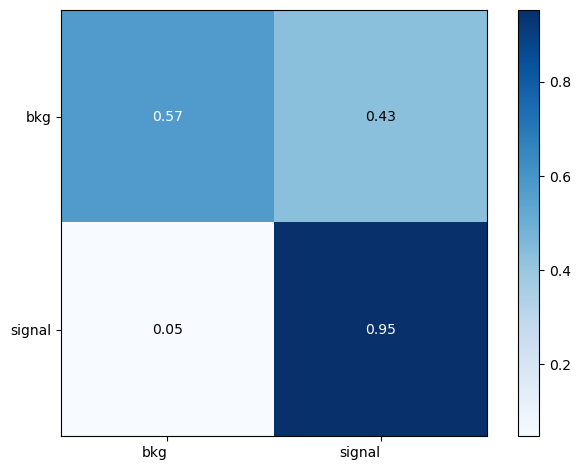

In [14]:
# confusion matrix and ROC for best RBF classifier
bestRBF = SVC(kernel='rbf', C=5, gamma=gamma_values[best_roc], probability=True)
bestRBF.fit(X_train_no_alpha, Y_train)
bestRBF_pred = bestRBF.predict(X_test2_no_alpha)
bestRBF_accuracy = skm.accuracy_score(Y_test2, bestRBF_pred)
bestRBF_prob = bestRBF.predict_proba(X_test2_no_alpha)
print(f'RBF kernel accuracy: {bestRBF_accuracy:.3f}')
auc_RBF = skm.roc_auc_score(Y_test2, bestRBF_prob[:,1])

labels, freqs = np.unique(Y_test2, return_counts=True) 
cm_RBF = skm.confusion_matrix(Y_test2, bestRBF_pred)
cm_RBF = cm_RBF/freqs[:,None]
betsRBF_Q = cm_RBF[1][1]/np.sqrt(cm_RBF[0][1])
print(f'\nRBF kernel Q factor: {betsRBF_Q:.2f}')

fig = plt.figure()

imRBF = plt.imshow(cm_RBF, cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)

fmt = '.2f'

thresh = cm_RBF.max() / 2.
for i in range(cm_RBF.shape[0]):
    for j in range(cm_RBF.shape[1]):
        plt.text(j, i, format(cm_RBF[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_RBF[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(imRBF, location = 'right') 
plt.show()

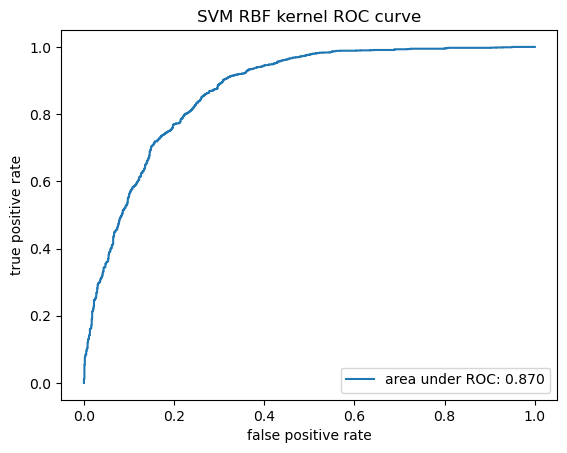

In [15]:
# plot ROC
fpr_RBF, tpr_RBF, t = skm.roc_curve(Y_test2, bestRBF_prob[:,1])

fig, ax = plt.subplots()

ax.plot(fpr_RBF, tpr_RBF, label=f'area under ROC: {auc_RBF:.3f}')
ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('SVM RBF kernel ROC curve')

plt.show()

### 5.2 Random Forest

In [16]:
# grid search: find the best model that maximize the area under the roc curve 
AUC = []

trees = np.arange(20,100,5)
depth = np.arange(10,32,2) # np.arange(25,50,1) 

for t in trees:
    for d in depth:
        # defining model
        model = RandomForestClassifier(n_jobs=-1, n_estimators=t, max_depth=d, max_features=4)
        # training on training set
        model.fit(X_train_no_alpha, Y_train)
        # validation on validation set
        prob = model.predict_proba(X_val_no_alpha)
        roc_auc = skm.roc_auc_score(Y_val, prob[:,1])
        pred = model.predict(X_val_no_alpha)
        acc = skm.accuracy_score(Y_val, pred)
        
        # save depth, #trees, area under ROC, accuracy
        AUC.append([d,t,roc_auc, acc])

<Axes: xlabel='trees', ylabel='depth'>

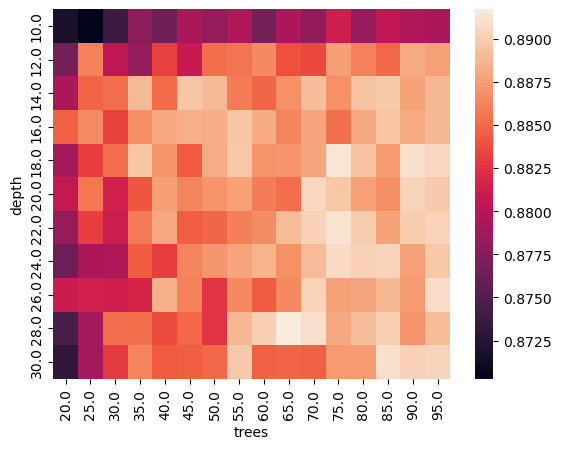

In [17]:
# visualizing grid search for maximizing auc
AUC = pd.DataFrame(np.array(AUC), columns=['depth', 'trees', 'auc', 'acc'])
grid_auc = AUC.pivot(index="depth", columns="trees", values="auc")
sns.heatmap(grid_auc)

In [18]:
# finding the best parameter model based on ROC  
max_index_auc = np.argmax(AUC['auc'])
best_auc = round(AUC['auc'].iloc[max_index_auc],3)
best_trees_auc = int(AUC['trees'].iloc[max_index_auc])
best_depth_auc = int(AUC['depth'].iloc[max_index_auc])
corr_acc = round(AUC['acc'].iloc[max_index_auc],3)

print('Best model that maximize area under ROC:')
print(' - depth',best_depth_auc)
print(' - trees', best_trees_auc)
print(' - auc', best_auc)
print(' - corresponding accuracy', corr_acc)

Best model that maximize area under ROC:
 - depth 28
 - trees 65
 - auc 0.892
 - corresponding accuracy 0.838


<Axes: xlabel='trees', ylabel='depth'>

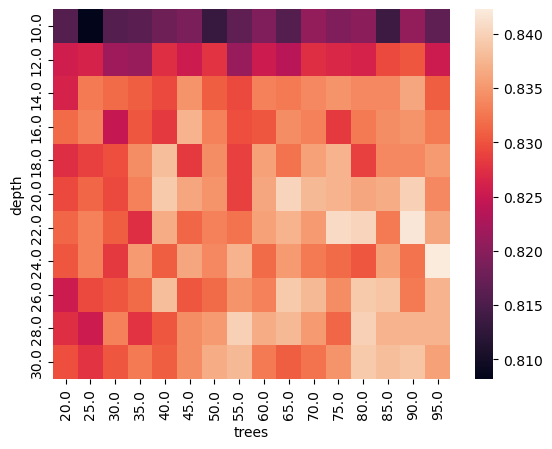

In [19]:
# visualizing grid search for maximizing accuracy
grid_acc = AUC.pivot(index="depth", columns="trees", values="acc")
sns.heatmap(grid_acc)

In [20]:
# finding the best parameter model based on accuracy  
max_index_acc = np.argmax(AUC['acc'])
best_acc = round(AUC['acc'].iloc[max_index_acc],3)
best_trees_acc = int(AUC['trees'].iloc[max_index_acc])
best_depth_acc = int(AUC['depth'].iloc[max_index_acc])
corr_auc = round(AUC['auc'].iloc[max_index_acc],3)

print('Best model that maximize accuracy:')
print(' - depth',best_depth_acc)
print(' - trees', best_trees_acc)
print(' - accuracy', best_acc)
print(' - corresponding auc', corr_acc)

Best model that maximize accuracy:
 - depth 24
 - trees 95
 - accuracy 0.842
 - corresponding auc 0.838


In [21]:
# best model based on maximizing auc
best_model_auc = RandomForestClassifier(n_estimators=best_trees_auc, max_depth=best_depth_auc) 
best_model_auc.fit(X_train_no_alpha, Y_train) 
best_model_pred_auc = best_model_auc.predict(X_test1_no_alpha)
best_model_prob_auc = best_model_auc.predict_proba(X_test1_no_alpha)

# accuracy and roc 
best_model_auc_acc = skm.accuracy_score(Y_test1, best_model_pred_auc)
print(f'Best random forest model accuracy: {best_model_auc_acc:.3f}')
best_model_auc_auc = skm.roc_auc_score(Y_test1, best_model_prob_auc[:,1])
print(f'Best random forest model area under ROC: {best_model_auc_auc:.3f}')

Best random forest model accuracy: 0.838
Best random forest model area under ROC: 0.892


In [22]:
# best model based on maximizing accuracy
best_model_acc = RandomForestClassifier(n_estimators=best_trees_acc, max_depth=best_depth_acc) 
best_model_acc.fit(X_train_no_alpha, Y_train) 
best_model_pred_acc = best_model_acc.predict(X_test1_no_alpha)
best_model_prob_acc = best_model_acc.predict_proba(X_test1_no_alpha)

# accuracy and roc 
best_model_acc_acc = skm.accuracy_score(Y_test1, best_model_pred_acc)
print(f'Best random forest model accuracy: {best_model_acc_acc:.3f}')
best_model_acc_auc = skm.roc_auc_score(Y_test1, best_model_prob_acc[:,1])
print(f'Best random forest model area under ROC: {best_model_acc_auc:.3f}')

Best random forest model accuracy: 0.839
Best random forest model area under ROC: 0.894


RBF kernel Q factor: 1.62


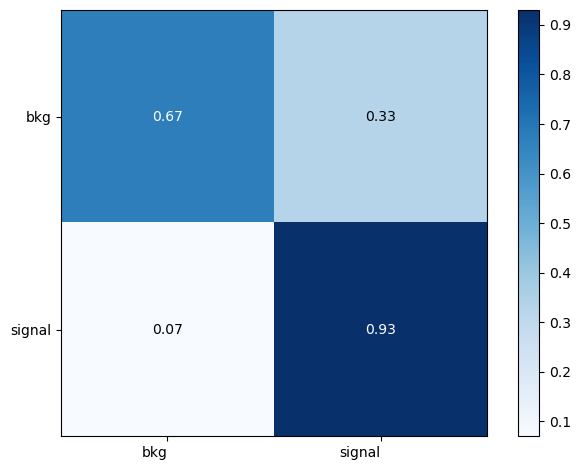

In [23]:
# confusion matrix from best model based on accuracy
labels, freqs = np.unique(Y_test1, return_counts=True) 
cm_RF = skm.confusion_matrix(Y_test1, best_model_pred_acc)
cm_RF = cm_RF/freqs[:,None]
betsRF_Q = cm_RF[1][1]/np.sqrt(cm_RF[0][1])
print(f'RBF kernel Q factor: {betsRF_Q:.2f}')

fig = plt.figure()

imRF = plt.imshow(cm_RF, cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)

fmt = '.2f'

thresh = cm_RF.max() / 2.
for i in range(cm_RF.shape[0]):
    for j in range(cm_RF.shape[1]):
        plt.text(j, i, format(cm_RF[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_RF[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(imRF, location = 'right') 
plt.show()

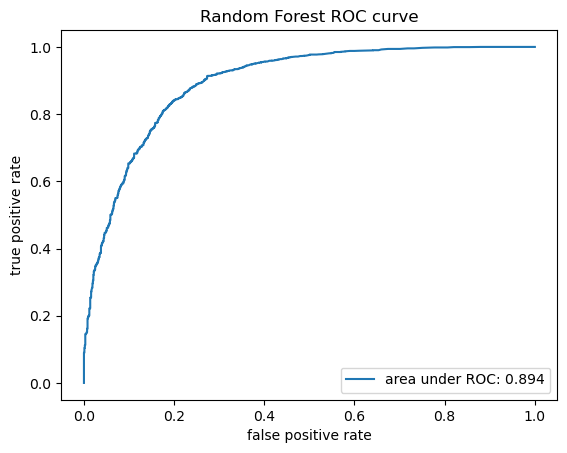

In [24]:
# plot ROC
fpr_rf, tpr_rf, _ = skm.roc_curve(Y_test1, best_model_prob_acc[:,1])

fig, ax = plt.subplots()

ax.plot(fpr_rf, tpr_rf, label=f'area under ROC: {best_model_acc_auc:.3f}')
ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('Random Forest ROC curve')

plt.show()

### 5.3 Neural Network

In [25]:
def grid_search(model, par, Xtrain, Ytrain, Xtest, Ytest):
    rocauc = [0,0]
    acc = [0,0]
    for lr in par['learning_rate_init']:
        for hidden_l in par['hidden_layer_sizes']:
            model.set_params(hidden_layer_sizes=hidden_l, learning_rate_init = lr)
            model.fit(Xtrain,Ytrain)
            pred = model.predict(Xtest)
            prob = model.predict_proba(Xtest)
            roc_auc = skm.roc_auc_score(Ytest, prob[:,1])
            a = skm.accuracy_score(Ytest, pred)
            print('architecture:', lr, hidden_l)
            
            if roc_auc > rocauc[0]:
                best_auc = [hidden_l, lr ]
                rocauc[0] = roc_auc
                rocauc[1] = a
            
            if a > acc[0]:
                best_acc = [hidden_l, lr ]
                acc[0] = a
                acc[1] = roc_auc

    return best_acc, acc, best_auc, rocauc 

In [26]:
# grid search on area under roc for best architecture
parameters = {'hidden_layer_sizes': [(32,), (64,), (32,16), (64,32), (64,32,16)], 
              'learning_rate_init': [0.2,0.02,0.002]}

NN_model = MLPClassifier(activation='relu', learning_rate = 'adaptive', alpha=0.05, max_iter=600)

print('NN grid search \n------------------------')
best_arch_acc, nn_acc, best_arch_auc, nn_auc = grid_search(NN_model, parameters, X_train_no_alpha, Y_train, X_val_no_alpha, Y_val)
print('-----------------------')

NN grid search 
------------------------
architecture: 0.2 (32,)
architecture: 0.2 (64,)
architecture: 0.2 (32, 16)
architecture: 0.2 (64, 32)
architecture: 0.2 (64, 32, 16)
architecture: 0.02 (32,)
architecture: 0.02 (64,)
architecture: 0.02 (32, 16)
architecture: 0.02 (64, 32)
architecture: 0.02 (64, 32, 16)
architecture: 0.002 (32,)
architecture: 0.002 (64,)
architecture: 0.002 (32, 16)
architecture: 0.002 (64, 32)
architecture: 0.002 (64, 32, 16)
-----------------------


In [28]:
print('Best NN architecture and learning rate based on maximizing accuracy:', best_arch_acc)
print(f'Corresponding accuracy and area under ROC: {nn_acc[0]:.3f}\t{nn_acc[1]:.3f}')
print('\nBest NN architecture and learning rate based on maximizing area under ROC:', best_arch_auc)
print(f'Corresponding accuracy and area under ROC: {nn_auc[1]:.3f}\t{nn_auc[0]:.3f}')

Best NN architecture and learning rate based on maximizing accuracy: [(64, 32, 16), 0.002]
Corresponding accuracy and area under ROC: 0.832	0.866

Best NN architecture and learning rate based on maximizing area under ROC: [(64, 32), 0.02]
Corresponding accuracy and area under ROC: 0.831	0.884


In [29]:
# best NN model based on maximizing accuracy (turns out to give best result on test)
bestNNmodel = MLPClassifier(activation='relu', hidden_layer_sizes = best_arch_acc[0], learning_rate_init=best_arch_acc[1], max_iter=600, learning_rate = 'adaptive', alpha=0.05)
bestNNmodel.fit(X_train_no_alpha, Y_train)
bestNNmodel_pred = bestNNmodel.predict(X_test1_no_alpha)
bestNNmodel_prob = bestNNmodel.predict_proba(X_test1_no_alpha)

# accuracy and roc 
bestNNmodel_acc = skm.accuracy_score(Y_test1, bestNNmodel_pred)
print(f'Best NN model accuracy: {bestNNmodel_acc:.3f}')
bestNNmodel_auc = skm.roc_auc_score(Y_test1, bestNNmodel_prob[:,1])
print(f'Best NN model area under ROC: {bestNNmodel_auc:.3f}')

Best NN model accuracy: 0.822
Best NN model area under ROC: 0.873


Neural network Q factor: 1.61


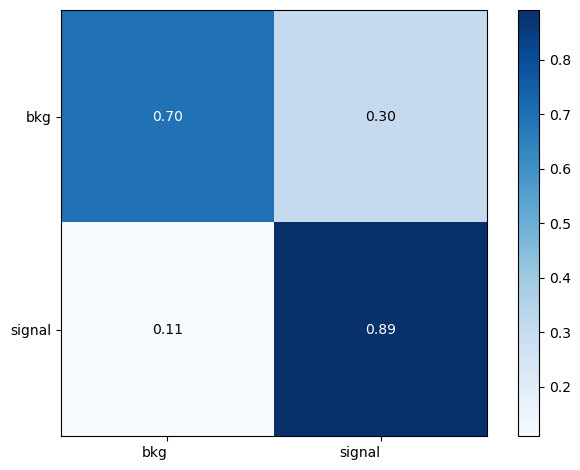

In [30]:
# confusion matrix
labels, freqs = np.unique(Y_test1, return_counts=True) 
cm_NN = skm.confusion_matrix(Y_test1, bestNNmodel_pred)
cm_NN = cm_NN/freqs[:,None]
betsNN_Q = cm_NN[1][1]/np.sqrt(cm_NN[0][1])
print(f'Neural network Q factor: {betsNN_Q:.2f}')

fig = plt.figure()

imNN = plt.imshow(cm_NN, cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)

fmt = '.2f'

thresh = cm_NN.max() / 2.
for i in range(cm_NN.shape[0]):
    for j in range(cm_NN.shape[1]):
        plt.text(j, i, format(cm_NN[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_NN[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(imNN, location = 'right') 
plt.show()

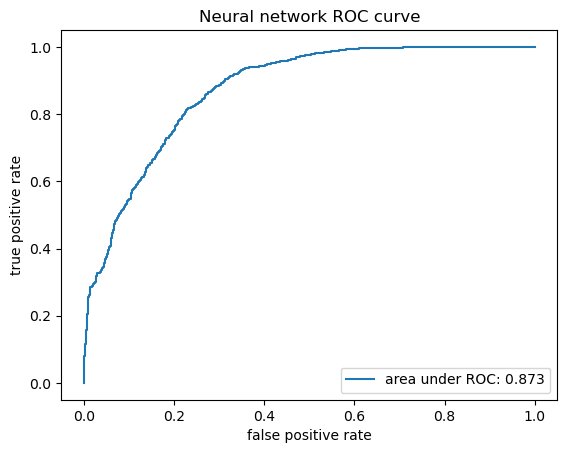

In [31]:
# plot ROC
fpr_NN, tpr_NN, _ = skm.roc_curve(Y_test1, bestNNmodel_prob[:,1])

fig, ax = plt.subplots()

ax.plot(fpr_NN, tpr_NN, label=f'area under ROC: {bestNNmodel_auc:.3f}')
ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('Neural network ROC curve')

plt.show()

### 5.4 Nearest Neighbours

In [32]:
# grid search for best k maximizing ROC auc
kappas = [k for k in range(5,101,5)]
kappas.insert(0,1)

best_knn_acc = [0,0,0]
best_knn_auc = [0,0,0]

# looping over kappas
for k in kappas:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    knn.fit(X_train_no_alpha, Y_train)
    knn_pred = knn.predict(X_val_no_alpha)
    knn_prob = knn.predict_proba(X_val_no_alpha)
    knn_auc = skm.roc_auc_score(Y_val, knn_prob[:, 1])
    knn_acc = skm.accuracy_score(Y_val, knn_pred)
    if knn_acc > best_knn_acc[2]:
        best_knn_acc = [k, knn_auc, knn_acc]
    if knn_auc > best_knn_auc[1]:
        best_knn_auc = [k, knn_auc, knn_acc]

print(f'Best number of neigbours that maximize ROC auc, corresponding ROC auc and accuracy: {best_knn_auc[0]}\t{best_knn_auc[1]:.3f}\t{best_knn_auc[2]:.3f}')
print(f'Best number of neigbours that maximize accuracy, corresponding ROC auc and accuracy: {best_knn_acc[0]}\t{best_knn_acc[1]:.3f}\t{best_knn_acc[2]:.3f}')

Best number of neigbours that maximize ROC auc, corresponding ROC auc and accuracy: 55	0.842	0.772
Best number of neigbours that maximize accuracy, corresponding ROC auc and accuracy: 10	0.825	0.795


In [33]:
# best kNN based on maximizing accuracy
kNNacc = KNeighborsClassifier(n_neighbors=best_knn_acc[0], weights='distance', n_jobs=-1)
kNNacc.fit(X_train_no_alpha, Y_train)
kNNacc_pred = kNNacc.predict(X_test1_no_alpha)
kNNacc_prob = kNNacc.predict_proba(X_test1_no_alpha)

kNNacc_acc = skm.accuracy_score(Y_test1, kNNacc_pred)
kNNacc_auc = skm.roc_auc_score(Y_test1, kNNacc_prob[:,1])
print(f'Best kNN model (based on accuracy) ROC auc and accuracy: {kNNacc_auc:.3f}\t{kNNacc_acc:.3f}')

Best kNN model (based on accuracy) ROC auc and accuracy: 0.832	0.798


In [34]:
# best kNN based on maximizing ROC auc
kNNauc = KNeighborsClassifier(n_neighbors=best_knn_auc[0], weights='distance', n_jobs=-1)
kNNauc.fit(X_train_no_alpha, Y_train)
kNNauc_pred = kNNauc.predict(X_test1_no_alpha)
kNNauc_prob = kNNauc.predict_proba(X_test1_no_alpha)

kNNauc_acc = skm.accuracy_score(Y_test1, kNNauc_pred)
kNNauc_auc = skm.roc_auc_score(Y_test1, kNNauc_prob[:,1])
print(f'Best kNN model (based on ROC auc) ROC auc and accuracy: {kNNauc_auc:.3f}\t{kNNauc_acc:.3f}')

Best kNN model (based on ROC auc) ROC auc and accuracy: 0.837	0.776


kNN Q factor: 1.27


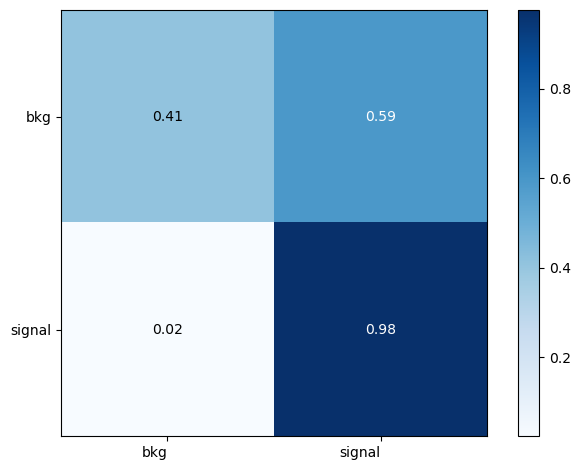

In [35]:
# confusion matrix
labels, freqs = np.unique(Y_test1, return_counts=True) 
cm_kNN = skm.confusion_matrix(Y_test1, kNNauc_pred)
cm_kNN = cm_kNN/freqs[:,None]
betskNN_Q = cm_kNN[1][1]/np.sqrt(cm_kNN[0][1])
print(f'kNN Q factor: {betskNN_Q:.2f}')

fig = plt.figure()

imkNN = plt.imshow(cm_kNN, cmap='Blues', interpolation='nearest')
plt.xticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)
plt.yticks([0,1], ['bkg', 'signal'],ha="right",rotation=0)

fmt = '.2f'

thresh = cm_kNN.max() / 2.
for i in range(cm_kNN.shape[0]):
    for j in range(cm_kNN.shape[1]):
        plt.text(j, i, format(cm_kNN[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_kNN[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(imkNN, location = 'right') 
plt.show()

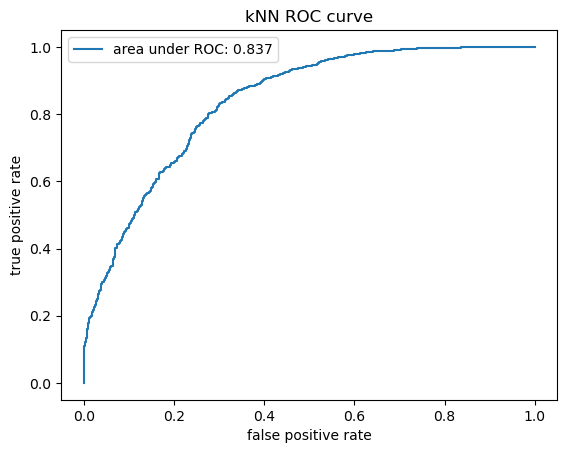

In [36]:
# plot ROC
fpr_kNN, tpr_kNN, _ = skm.roc_curve(Y_test1, kNNauc_prob[:,1])

fig, ax = plt.subplots()

ax.plot(fpr_kNN, tpr_kNN, label=f'area under ROC: {kNNauc_auc:.3f}')
ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('kNN ROC curve')

plt.show()

### 5.5 Classifiers comparison

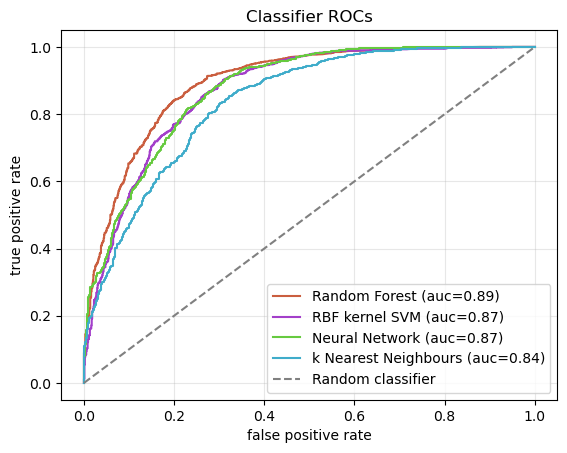

In [37]:
fig, ax = plt.subplots()
ax.grid(alpha = 0.3)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (auc={best_model_acc_auc:.2f})', color = '#ca5e3f')
ax.plot(fpr_RBF, tpr_RBF, label=f'RBF kernel SVM (auc={auc_RBF:.2f})', color = '#a33fca')
ax.plot(fpr_NN, tpr_NN, label=f'Neural Network (auc={bestNNmodel_auc:.2f})', color = '#66ca3f')
ax.plot(fpr_kNN, tpr_kNN, label=f'k Nearest Neighbours (auc={kNNauc_auc:.2f})', color = '#3facca')
ax.plot(fpr_kNN, fpr_kNN, label = 'Random classifier', linestyle = 'dashed', color = 'grey')

ax.legend()
ax.set_ylabel('true positive rate')
ax.set_xlabel('false positive rate')
ax.set_title('Classifier ROCs')

plt.savefig('classifierROCs.png', dpi=600)

plt.show()

### 5.6 Best classifier: RF

In [ ]:
# analize RF ROC

<BarContainer object of 9 artists>

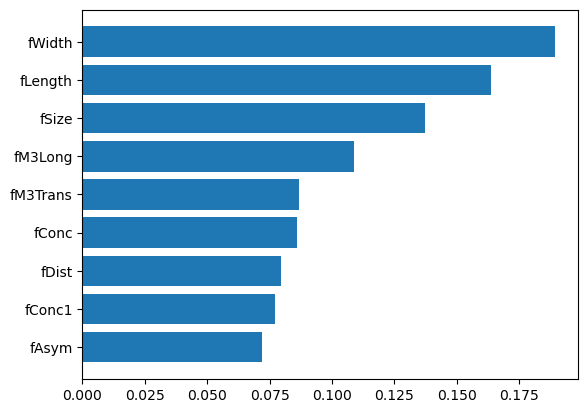

In [48]:
# feature importance in RF
sort = best_model_acc.feature_importances_.argsort()
plt.barh(X_train_no_alpha.columns[sort], best_model_acc.feature_importances_[sort]) 


In [50]:
# feature importance with Alpha

best_model_acc.fit(X_train, Y_train) 
best_model_pred_acc_alpha = best_model_acc.predict(X_test1)
best_model_prob_acc_alpha = best_model_acc.predict_proba(X_test1)

# accuracy and roc 
best_model_acc_acc_alpha = skm.accuracy_score(Y_test1, best_model_pred_acc_alpha)
print(f'Best random forest model accuracy: {best_model_acc_acc_alpha:.3f}')
best_model_acc_auc_alpha = skm.roc_auc_score(Y_test1, best_model_prob_acc_alpha[:,1])
print(f'Best random forest model area under ROC: {best_model_acc_auc_alpha:.3f}')

Best random forest model accuracy: 0.886
Best random forest model area under ROC: 0.938


<BarContainer object of 10 artists>

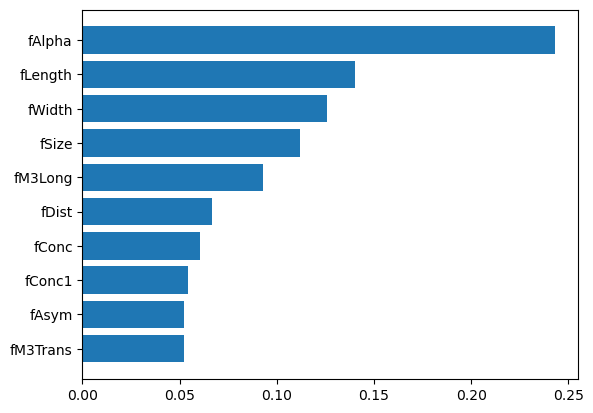

In [52]:
sort = best_model_acc.feature_importances_.argsort()
plt.barh(X_train.columns[sort], best_model_acc.feature_importances_[sort]) 

### 6. Gammaness and Alpha Cuts

In [40]:
# now we define n dataset with n = number of alpha cuts 
alpha_cut = np.arange(1,90,1)
alpha_set = []

for a in alpha_cut: 
    alpha_set.append([X_test1_no_alpha[X_test1['fAlpha']<= a], Y_test1[X_test1['fAlpha']<= a], a])

gammaness = np.arange(0.6,0.9,0.01)

In [41]:
# for each dataset we compute the quality factor of the best model for different values of gammaness
q_fact = []

for data in alpha_set:

    prob = best_model_acc.predict_proba(data[0])
    
    q_fact_gam = []

    for g in gammaness:
        prob_g = np.where(prob[:,1]>g,1,0)
        confusion_SVM = skm.confusion_matrix(data[1], prob_g, normalize='true')
        if np.sqrt(confusion_SVM[0,1]) != 0:
            q = confusion_SVM[1,1]/np.sqrt(confusion_SVM[0,1])
            q_fact_gam.append(q)

    q_fact.append(q_fact_gam)

<Axes: >

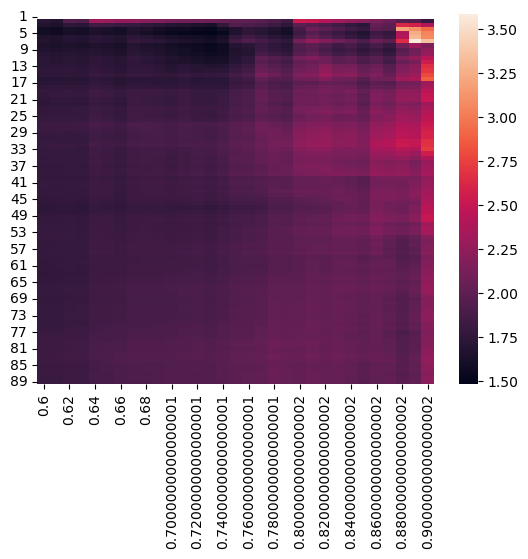

In [47]:
# plot
QQ = pd.DataFrame(q_fact, index=alpha_cut, columns=gammaness)
sns.heatmap(QQ, xticklabels='auto', yticklabels='auto')

In [45]:
best_gammaness = QQ.max().idxmax()
best_q = QQ.max().max()
best_alphacut = QQ.max(axis='columns').idxmax()
print(f'Best gammaness: {best_gammaness:.3f}')
print('Best alpha cut:', best_alphacut)
print(f'Maximum Q value: {best_q:.2f}')

Best gammaness: 0.890
Best alpha cut: 7
Maximum Q value: 3.58


### 7. Observation time

### 7.1 HEGRA

### 7.2 MAGIC

### 7.3 Spectra comparison